In [1]:
import sys
sys.path.insert(0, "/global/u1/p/prakharb/desilike")
import desilike, inspect
print(inspect.getfile(desilike))

/global/u1/p/prakharb/desilike/desilike/__init__.py


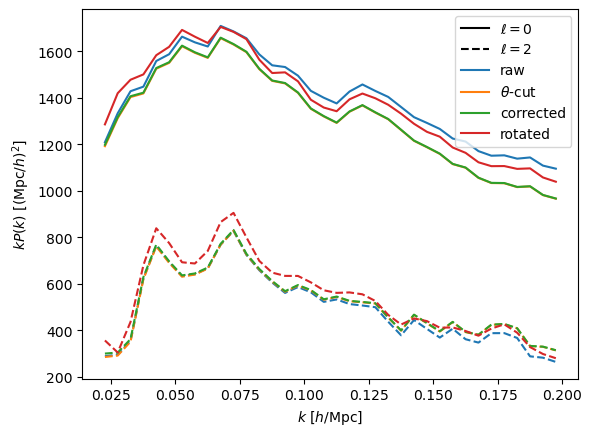

In [2]:
from pathlib import Path

tracer, zrange = 'LRG', (0.4, 0.6)
data_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/baseline_2pt/pk')

from pypower import PowerSpectrumMultipoles
raw = PowerSpectrumMultipoles.load(data_dir / f'pkpoles_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}.npy')
thetacut = PowerSpectrumMultipoles.load(data_dir / f'pkpoles_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')
corrected = PowerSpectrumMultipoles.load(data_dir / 'corrected' / f'pkpoles_corrected_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')
rotated = PowerSpectrumMultipoles.load(data_dir / 'rotated_corrected' / f'pkpoles_rotated_corrected_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')

klim = (0.02, 0.2, 0.005)
raw = raw.select(klim)
thetacut = thetacut.select(klim)
corrected = corrected.select(klim)
rotated = rotated.select(klim)

from matplotlib import pyplot as plt

ax = plt.gca()
linestyles = {0: '-', 2: '--', 4: ':'}
for ill, ell in enumerate([0, 2]):
    ax.plot([], [], linestyle=linestyles[ell], color='k', label=r'$\ell = {:d}$'.format(ell))
for ill, ell in enumerate([0, 2]):
    linestyle = linestyles[ell]
    ax.plot(raw.k, raw.k * raw(ell=ell, complex=False), color='C0', label='raw' if ill == 0 else None, linestyle=linestyle)
    ax.plot(thetacut.k, thetacut.k * thetacut(ell=ell, complex=False), color='C1', label=r'$\theta$-cut' if ill == 0 else None, linestyle=linestyle)
    ax.plot(corrected.k, corrected.k * corrected(ell=ell, complex=False), color='C2', label=r'corrected' if ill == 0 else None, linestyle=linestyle)
    ax.plot(rotated.k, rotated.k * rotated(ell=ell, complex=False), color='C3', label=r'rotated' if ill == 0 else None, linestyle=linestyle)
ax.legend(loc=1)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^2$]')
plt.show()

In [3]:
from pathlib import Path

import numpy as np
from desilike.observables import ObservableCovariance

tracer, zrange = 'LRG', (0.8, 1.1)

forfit_dir = Path('/global/cfs/cdirs/desi//survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/')
ref_fn = forfit_dir / f'forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}.npy'
covariance = ObservableCovariance.load(ref_fn)

# P(k)
observable_power = covariance.observables('power')
ells_power = observable_power.projs  # (0, 2)
data_power = observable_power.view(projs=ells_power)
zeff_power = observable_power.attrs['zeff']
wmatrix_power = observable_power.attrs['wmatrix']
kin_power = observable_power.attrs['kin']

# BAO
observable_bao = covariance.observables('bao-recon')
params_bao = observable_bao.projs # qpar, qper
data_bao = observable_bao.view(projs=params_bao)
zeff_bao = observable_bao.attrs['zeff']

# Inverse covariance matrix, with all systematic corrections
invcov = covariance.inv()
# To select a part only
invcov_power = covariance.select(observables='power', select_observables=True).inv()

# Define chi2 = (d - W t)^T C^(-1) (d - W t)
def chi2(theory_power, theory_bao):
    diff = data_power - wmatrix_power.dot(theory_power)
    diff = np.append(diff, data_bao - theory_bao)
    return diff.dot(invcov).dot(diff)

In [4]:
# Try with Kaiser model
from cosmoprimo.fiducial import DESI
cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(kin_power, z=zeff_power)
f, b = cosmo.growth_rate(zeff_power), 2.

theory_power = []
theory_power.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk)
theory_power.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
theory_power.append(8. / 35 * f**2 * pk)

theory_bao = []
fiducial = DESI()  # DESI fiducial cosmology
theory_bao.append(cosmo.comoving_radial_distance(zeff_bao) / cosmo.rs_drag / (fiducial.comoving_radial_distance(zeff_bao) / fiducial.rs_drag))
theory_bao.append(1. / cosmo.efunc(zeff_bao) / cosmo.rs_drag / (1. / fiducial.efunc(zeff_bao) / fiducial.rs_drag))

print('chi2 is', chi2(np.ravel(theory_power), np.ravel(theory_bao)))

chi2 is 156.50230630433373


In [4]:
import numpy as np
from matplotlib import pyplot as plt

from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.theories.galaxy_clustering.full_shape import FOLPSv2TracerPowerSpectrumMultipoles
from desilike.observables import ObservableCovariance
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike import setup_logging

setup_logging()

template = FixedPowerSpectrumTemplate(z=zeff_power)
# theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, tracer='ELG', prior_basis='physical')
theory = FOLPSv2TracerPowerSpectrumMultipoles(template=template, tracer='ELG', prior_basis='standard',freedom='max',kernels='eds')
covariance = ObservableCovariance.load(ref_fn)
data = covariance.observables('power')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=covariance.select(observables=data, select_observables=True), wmatrix=data.attrs['wmatrix'], theory=theory, kin=data.attrs['kin'], ellsin=data.attrs['ellsin'], wshotnoise=data.attrs['wshotnoise'])
likelihood = ObservablesGaussianLikelihood(observables=[observable])

profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))

[000000.31] [0/1] 07-29 15:23  ObservableCovariance      INFO     Loading /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_LRG_GCcomb_z0.8-1.1.npy.
✅ Using NumPy with CPU.
Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
[000003.16] [0/1] 07-29 15:23  MinuitProfiler            INFO     Varied parameters: ['b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'X_FoG_p'].
[000004.21] [0/1] 07-29 15:23  MinuitProfiler            INFO     Could *not* jit input likelihood.
[000004.21] [0/1] 07-29 15:23  MinuitProfiler            INFO     Could *not* vmap input likelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.
[000004.31] [0/1] 07-29 15:23  TaskManager               INFO     Entering TaskManager with 1 workers.
+--------------------------------------+--------+---------+-------+
| chi2 / (72 - 10) = 44.27 / 62 = 0.71 | varied | bestfit | error |
+--------------------------------------+--------+---------+-------+
|                  b1                  |  True  |  2.270  | 0.077 |
|                  b2                  |  True  |   -4    |  11   |
|                  bs               

In [5]:
theory.all_params

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
ParameterCollection(['ct'])
Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


ParameterCollection(['b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'ct', 'sn0', 'sn2', 'X_FoG_p'])

In [6]:
likelihood.all_params

ParameterCollection(['b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'ct', 'sn0', 'sn2', 'loglikelihood', 'logprior'])

In [7]:
import folps 